In [11]:
import pandas as pd
import glob
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [12]:
# Load the master dataset
master_data = pd.read_csv(r"C:\Users\DELL\Desktop\vocational traning\project 1\master_data.csv")


subject_files = sorted(glob.glob(r'C:\Users\DELL\Desktop\vocational traning\project 1\subject_*.csv'))

subject_dfs = []

for file in subject_files:
    df = pd.read_csv(file)
    
    subject_id = int(os.path.basename(file).split("_")[1].split(".")[0]) #subject id extraction from file 
    
    df['subject_id'] = subject_id  #this make sure thata sub id is present 
    subject_dfs.append(df)
    print(f"Subject {subject_id} loaded")
    print(df.head(2))

Subject 1 loaded
       time  ppg_signal  subject_id
0  0.000000   -0.005162           1
1  0.010002    0.115503           1
Subject 10 loaded
       time  ppg_signal  subject_id
0  0.000000    0.004189          10
1  0.010002    0.096108          10
Subject 11 loaded
       time  ppg_signal  subject_id
0  0.000000    0.001796          11
1  0.010002    0.071022          11
Subject 12 loaded
       time  ppg_signal  subject_id
0  0.000000    0.004562          12
1  0.010002    0.116440          12
Subject 13 loaded
       time  ppg_signal  subject_id
0  0.000000   -0.024996          13
1  0.010002    0.117050          13
Subject 14 loaded
       time  ppg_signal  subject_id
0  0.000000   -0.006506          14
1  0.010002    0.107230          14
Subject 15 loaded
       time  ppg_signal  subject_id
0  0.000000   -0.015861          15
1  0.010002    0.115152          15
Subject 16 loaded
       time  ppg_signal  subject_id
0  0.000000    0.001874          16
1  0.010002    0.102974      

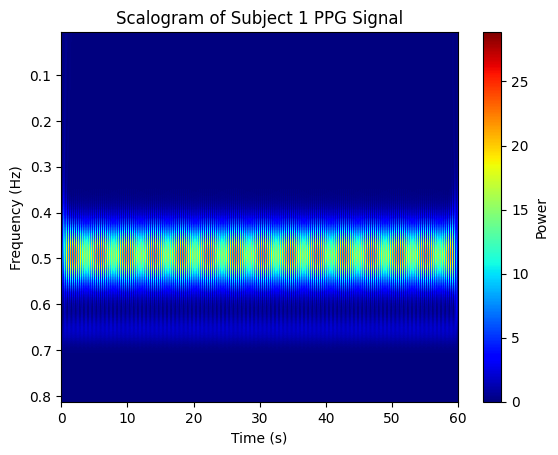

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Load subject 1 data
subject_1_df = pd.read_csv(r'C:\\Users\\DELL\\Desktop\\vocational traning\\project 1\\subject_1.csv')

# Extract the PPG signal
signal = subject_1_df['ppg_signal'].values

# Perform Continuous Wavelet Transform (CWT)
coefficients, frequencies = pywt.cwt(signal, scales=np.arange(1, 128), wavelet='morl')

# Plot the scalogram
plt.imshow(np.abs(coefficients)**2, cmap='jet', aspect='auto',
           extent=[subject_1_df['time'].min(), subject_1_df['time'].max(), frequencies.min(), frequencies.max()])
plt.colorbar(label='Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Scalogram of Subject 1 PPG Signal')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm



# 📂 Set folder paths (updated to match your previous project)
project_root = "C:\\Users\\DELL\\Desktop\\vocational traning\\project 1\\"
data_folder = os.path.join(project_root, "subjects")  # Assuming CSV files are here
scalogram_folder = os.path.join(project_root, "scalograms")  # For storing generated scalograms

# Create directories if they do not exist
os.makedirs(data_folder, exist_ok=True)
os.makedirs(scalogram_folder, exist_ok=True)

# 📌 Load CSV files
file_list = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print("Found files:", file_list)



# 📌 Function to generate scalogram image
def generate_scalogram(signal, filename, wavelet='morl', scales=np.arange(1, 128)):
    coefficients, _ = pywt.cwt(signal, scales, wavelet)
    power = np.abs(coefficients)**2
    plt.figure(figsize=(6, 4))
    plt.imshow(power, extent=[0, len(signal), 1, 128], cmap='jet', aspect='auto', vmax=np.percentile(power, 99))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()






# 📌 Generate scalograms and labels
X = []
y = []

for file_path in tqdm(file_list):
    df = pd.read_csv(file_path)
    signal = df['ppg_signal'].values  # Using 'ppg_signal' column as per your previous code
    file_name = os.path.basename(file_path).replace(".csv", ".png")
    save_path = os.path.join(scalogram_folder, file_name)

    if generate_scalogram(signal[:2000], save_path):  # Use first 2000 samples
        img = cv2.imread(save_path)
        if img is None:
            print(f"Failed to load image: {save_path}")
        else:
            img = cv2.resize(img, (128, 128))
            X.append(img)

        # Using random labels as placeholder (replace with actual values if available)
        dummy_label = np.random.uniform(80, 180)
        y.append(dummy_label)
X = np.array(X)
y = np.array(y)
print("Shape of X:", X.shape, "Shape of y:", y.shape)

# 📌 Normalize images
X = X / 255.0

# 📌 Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)






# Convert to PyTorch tensors (channel-first format)
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 📌 Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 input channels (RGB)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 64)  # 128x128 -> 64x64 -> 32x32 -> 16x16 after pooling
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 📌 Training
num_epochs = 30
batch_size = 8

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(X_train):.4f}')

# 📌 Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nEvaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 📌 Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test.numpy(), y_pred.numpy(), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()


Found files: []


0it [00:00, ?it/s]

Shape of X: (0,) Shape of y: (0,)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.